# 分子動力学シミュレーション(Molecular Dynamics; MD)

古典分子動力学(MD)シミュレーションは、以下に示す2体間に働くポテンシャル $V(\boldsymbol{r}_1,\boldsymbol{r}_2)$のもとでの $N$ 粒子系のニュートンの運動方程式を解くことで、粒子の運動を決定する手法である:
$$
m_i \ddot{\boldsymbol{r}}_i = - \sum_{j \neq i} \nabla_i V(\boldsymbol{r}_i,\boldsymbol{r}_j)~.
$$

もし系が十分大きければ、分子動力学法を使って、系のマクロな性質を調べることができる。たとえば、熱力学的な性質で圧力の温度・密度依存性、すなわち気体の状態方程式を計算することができる。


大体の場合、2体間ポテンシャルは相対距離 $r_{ij} = |\boldsymbol{r}_i - \boldsymbol{r}_j|$ のみに依存する。
この場合、運動方程式は以下のようになる：
$$
m_i \ddot{\boldsymbol{r}}_i = - \sum_{j \neq i} \frac{d V(r_{ij})}{d r_{ij}} \, \frac{\boldsymbol{r}_i - \boldsymbol{r}_j}{r_{ij}}~.
$$



分子動力学シミュレーションで以下の物理量を計算する。
- 力（加速度）: $ \boldsymbol{F}_{ij} = - \nabla_i V(r_{ij}) $
- 運動エネルギー:
$ K = \sum_i \frac12 m \boldsymbol{v}_i^2 $
- 温度: $T_{\rm kin} = \frac{2K}{3N k_{\rm B}}$
- 圧力: $p = \rho k_{\rm B} T_{\rm kin} + \frac{1}{3V} \sum_{i = 1}^N \sum_{j>i}^N \boldsymbol{r}_{ij} \cdot \boldsymbol{F}_{ij}$

一般に $\sum_{i = 1}^N \sum_{j>i}^N \boldsymbol{r}_{ij} \cdot \boldsymbol{F}_{ij}$ のことを*ビリアル*という。

## Lennard-Jones ポテンシャル

Lennard-Jones ポテンシャルは
$$
V_{LJ}(r) = 4 \varepsilon \left[ \left(\frac{\sigma}{r}\right)^{12} - \left(\frac{\sigma}{r}\right)^6 \right].
$$

The Lennard-Jones 物質の相図は気体・液体・固体やそれらの間の相転移を含み、豊かな総構造を示す。

![LJPD](LJ_phase_diagram.gif)

Lennard-Jones 物質の性質を調べるためには、MDシミュレーションを十分長い時間走らせて、系が平衡化するまで待つ。そして、圧力などのマクロな物理量を計算する。

シミュレーションは、通常、有限体積効果が効かないように周期境界条件を課した箱の上で行う。

## 速度 Verlet 法

長い MD シミュレーションのためには、安定でなければならない。また、時間反転対称で、エネルギーを保存する解法が好ましい。
そのような方法として leap frog 法が知られる。特に、Newtonの運動方程式に応用される文脈では速度 Verlet 法として知られる。

運動方程式を解く：
$$
\frac{d^2 x}{dt^2} = f(x,t).
$$
1階の連立微分方程式として書き直せる：
\begin{align*}
\frac{dx}{dt} &= v, \\
\frac{dv}{dt} &= f(x,t).
\end{align*}

Leapfrog法を適用すると
\begin{align*}
x(t+h) & = x(t) + h v(t + h/2), \\
v(t+3h/2) &= v(t+h/2) + h f[x(t+h), t+h)],
\end{align*}
となる。つまり、空間座標は整数倍のステップで、速度は半整数のステップで見積もられる。

これが速度 Verlet 法の概要である。
空間座標は半整数ステップでは見積もる必要がなく、一方速度は整数ステップでは見積もる必要がないので計算量の節約にもなる。
もちろん整数ステップでの速度も見積もることができる$v(t+h) = v(t+h/2) + (h/2) f[x(t+h),t+h]$.

速度 Verlet 法のアルゴリズムは以下の通りである。時刻 t での初期条件 $x(t)$, $v(t)$ が与えられた時、
$$
v(t+h/2) = v(t) + \frac{h}{2} f[x(t),t].
$$
各ステップでの速度 Verlet 法は
\begin{align*}
v(t+h/2) & = v(t) + \frac{h}{2} f[x(t),t],\\
x(t+h) & = x(t) + h v(t+h/2), \\
v(t+h) & = v(t+h/2) + \frac{h}{2} f[x(t+h),t+h)].
\end{align*}

以下に、任意の中心力ポテンシャルのもとでの Newton 運動方程式を解くコードを書く。

In [ ]:
import numpy as np

# シミュレーションのパラメタ（以下で変更する）
n_particles = 125      # 粒子数
density     = 0.8      # 粒子密度
box_length = (n_particles/density)**(1/3.)  # シミュレーションの箱のサイズ（粒子数と密度で決まる）
temperature0 = 1.0    # 初期の系の温度
time_step = 0.004     # シミュレーションの時間ステップ
num_steps = 1000      # シミュレーションのステップ数


# 初期化
# 各単位格子上でに粒子を配置する
# # 粒子が重なるのを防ぐ
def initial_positions():
    ret = np.zeros((n_particles,3))
    Nsingle = np.ceil(n_particles**(1/3.))
    dL = box_length / Nsingle
    for i in range(n_particles):
        ix = i % Nsingle
        iy = (np.trunc(i / Nsingle)) % Nsingle
        iz = np.trunc(i / (Nsingle * Nsingle))
        ret[i][0] = (ix + 0.5) * dL
        ret[i][1] = (iy + 0.5) * dL
        ret[i][2] = (iz + 0.5) * dL
    return ret

# 与えられた位置ベクトルについて、力とポテンシャルとポテンシャルの勾配を計算。
# 以下のタプルを返す: 位置, 全ポテンシャルエネルギー, 圧力のビリアル部分（位置と運動量の内積）
def compute_forces(forces, positions, potential, potential_gradient):
    forces.fill(0.)
    potential_energy = 0.0
    virial = 0.0
    for i in range(n_particles):
        for j in range(i+1, n_particles):
            # 相対位置ベクトル
            r_ij = positions[i] - positions[j]
            # 周期境界条件 (minimum-image convention)
            r_ij = r_ij - box_length*np.round(r_ij/box_length)
            
            r_sq = np.sum(r_ij**2)
            f_ij = -potential_gradient(r_sq) * r_ij
            
            forces[i] += f_ij
            forces[j] -= f_ij
            potential_energy += potential(r_sq)
            virial += np.dot(f_ij, r_ij)
            
    virial = virial/(3.0*box_length**3)
    return forces, potential_energy, virial


# 運動エネルギーから温度を計算（気体分子運動論）
def compute_kinetic_temperature(velocities):
    return np.sum(velocities**2) / 3. / n_particles


# 速度 Verlet 法の各ステップ
# 以下のタプルを返す：新しい座標, 速度, 加速度（力）, ポテンシャルエネルギー, 圧力
def velocity_verlet(positions, velocities, accelerations, 
                    time_step, potential, potential_gradient):
    # 座標の更新
    positions += velocities*time_step + 0.5*accelerations*time_step**2
    positions = positions - box_length*np.floor(positions/box_length)
    # 速度の更新
    velocities_half = velocities + 0.5*accelerations*time_step
    # 新たに加速度とポテンシャルを計算
    accelerations, potential_energy, pressure = compute_forces(accelerations, positions, potential, potential_gradient)
    # 新たに計算した加速度を使って速度を更新
    velocities = velocities_half + 0.5*accelerations*time_step
    # 圧力に自由気体の寄与を追加
    kinetic_temperature = compute_kinetic_temperature(velocities)
    pressure += density * kinetic_temperature
    return positions, velocities, accelerations, potential_energy, pressure


Lennard-Jones ポテンシャルの性質

In [ ]:
# 距離の2乗についての Lennard-Jones ポテンシャル
def lj_potential(r_sq):
    r6 = r_sq**3
    r12 = r6**2
    return 4.0*(1./r12 - 1./r6)

# LJ ポテンシャルについての、運動方程式の右辺に現れる勾配項 dV/dr / r
def lj_potential_gradient(r_sq):
    r6 = r_sq**3
    r12 = r6**2
    return -24.0*(2./r12 - 1./r6) / r_sq

シミュレーションを走らせる：

In [ ]:
# シミュレーションのパラメタ
n_particles = 64       # 粒子数
density     = 0.1      # 粒子密度
box_length = (n_particles/density)**(1/3.)  # ボックスのサイズ（粒子数と密度で指定）
temperature0 = 1.0     # 初期の系の温度
time_step = 0.01       # シミュレーションの各時間ステップ
num_steps = 1000       # シミュレーションのステップ数

averaging_steps = 100  # 最後に時間平均をとるときのステップ数


# 初期化
positions = initial_positions() # 格子上に粒子を配置（座標の初期化）
velocities = np.random.normal(loc=0.0, scale=np.sqrt(temperature0), size=(n_particles, 3)) # 速度の初期化。Maxwell-Boltzmann分布から速度をサンプル
accelerations = np.zeros((n_particles, 3)) # 加速度の初期化（全部ゼロ）
t = 0 # 時刻の初期化

accelerations, potential_energy, pressure = compute_forces(accelerations, positions, lj_potential, lj_potential_gradient) # 加速度、ポテンシャル、圧力の初期化
kinetic_energy = 0.5*np.sum(velocities**2) # 運動エネルギーの初期化
total_energy = potential_energy + kinetic_energy # 全エネルギーの初期化
temperature = temperature0 # 温度の初期化

times = [] # 時刻を格納する配列
kinetic_energies = [] # 運動エネルギーの配列
potential_energies = [] # ポテンシャルの配列
total_energies = [] # 全エネルギーの配列
temperatures = [] # 温度の配列
compressibilities = [] # 圧縮率の配列

# 各配列の末尾に現在の値を加える：
times.append(t)
kinetic_energies.append(kinetic_energy / n_particles)
potential_energies.append(potential_energy / n_particles)
total_energies.append(total_energy / n_particles)
temperatures.append(temperature)
compressibilities.append(pressure / (temperature * density))

print("Kinetic energy \t Potential energy \t Total energy \t Temperature \t Compressibility")
print(kinetic_energy / n_particles,"\t",
      potential_energy / n_particles,"\t",
      total_energy / n_particles, "\t", 
      temperature, "\t", 
      pressure / (temperature * density))

# Main のループ計算(粒子数、ステップ数によりますが、時間がかかります)
for step in range(num_steps):
    # 速度 Verlet 法
    positions, velocities, accelerations, potential_energy, pressure = velocity_verlet(positions, velocities, accelerations, time_step, lj_potential, lj_potential_gradient)
    # 運動エネルギーの計算
    kinetic_energy = 0.5*np.sum(velocities**2)
    # 全エネルギーの計算
    total_energy = potential_energy + kinetic_energy
    # 温度と圧力の計算
    temperature = 2.0*kinetic_energy/(3.0*n_particles)
    # 時刻を更新
    t += time_step
    
    # 配列の末尾に今計算した値を加える
    times.append(t)
    kinetic_energies.append(kinetic_energy / n_particles)
    potential_energies.append(potential_energy / n_particles)
    total_energies.append(total_energy / n_particles)
    temperatures.append(temperature)
    compressibilities.append(pressure / (temperature * density))
    
    # 結果の print
    if step % 100 == 0:
        print(kinetic_energy / n_particles,"\t",
              potential_energy / n_particles,"\t",
              total_energy / n_particles, "\t", 
              temperature, "\t", 
              pressure / (temperature * density))

Kinetic energy 	 Potential energy 	 Total energy 	 Temperature 	 Compressibility
1.216800318200875 	 -0.15894785673871592 	 1.0578524614621592 	 1.0 	 -0.3154156116256416
1.216895020825098 	 -0.15906826109293737 	 1.0578267597321607 	 0.811263347216732 	 0.6109146762078819
1.6064955143025588 	 -0.5488587021928608 	 1.057636812109698 	 1.0709970095350392 	 0.6099940469686759
1.7466701183958937 	 -0.6891716249781505 	 1.0574984934177432 	 1.1644467455972625 	 0.7512497790646521
1.8351635471055887 	 -0.7781644354817314 	 1.0569991116238573 	 1.2234423647370591 	 0.6480840776909222
1.8457948218209608 	 -0.7893086802269416 	 1.0564861415940192 	 1.2305298812139738 	 0.8726051747316821
1.8267839822552352 	 -0.7700365121300407 	 1.0567474701251944 	 1.2178559881701567 	 1.3130280561878962
1.7953211755956202 	 -0.7377240866858769 	 1.0575970889097435 	 1.1968807837304134 	 0.6771562226376725
1.873316088802262 	 -0.8160599512878426 	 1.0572561375144194 	 1.2488773925348413 	 0.704527148968598
1

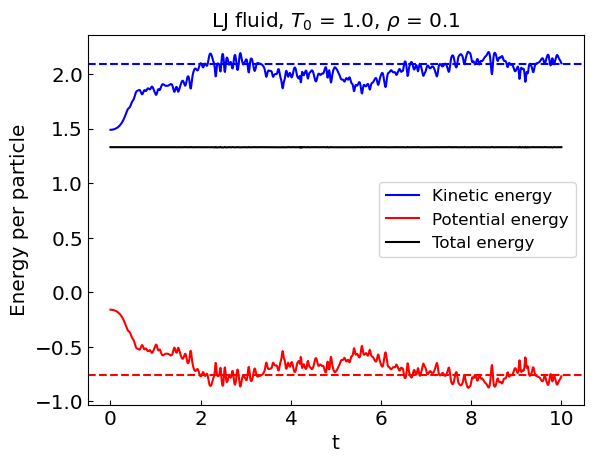

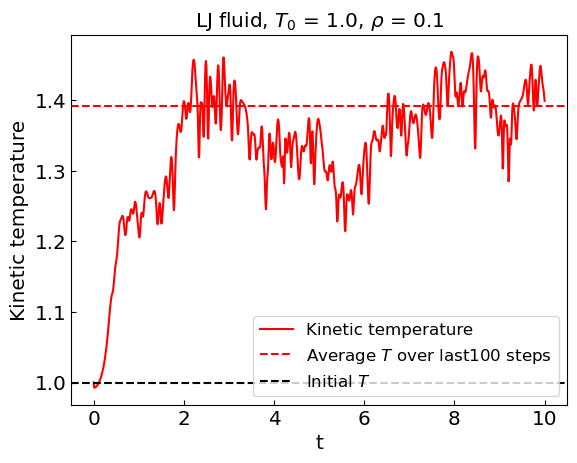

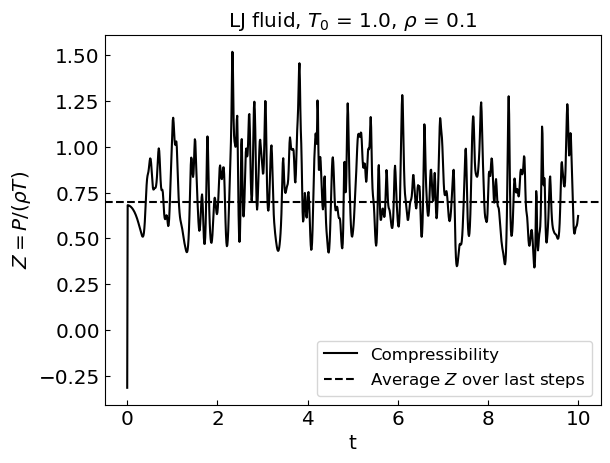

In [6]:
# 可視化
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large',
         'xtick.direction':'in',
         'ytick.direction':'in',
         }
plt.rcParams.update(params)

# 最後の数ステップ(averaging_steps で定義)での運動エネルギーK, ポテンシャルV, 温度T, 圧縮率Zの平均：
Kav = np.sum(kinetic_energies[-averaging_steps:])/averaging_steps
Vav = np.sum(potential_energies[-averaging_steps:])/averaging_steps
Tav = np.sum(temperatures[-averaging_steps:])/averaging_steps
Zav = np.sum(compressibilities[-averaging_steps:])/averaging_steps

# エネルギーのプロット
plt.plot(times, kinetic_energies, label = 'Kinetic energy', color = 'blue')
plt.axhline(y = Kav, linestyle = '--', color = 'blue')
plt.plot(times, potential_energies, label = 'Potential energy', color = 'red')
plt.axhline(y = Vav, linestyle = '--', color = 'red')
plt.plot(times, total_energies, label = 'Total energy', color = 'black')
plt.xlabel('t')
plt.ylabel('Energy per particle')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()

# 温度のプロット
plt.plot(times, temperatures, label = 'Kinetic temperature', color = 'red')
plt.axhline(y = Tav, color = 'red', linestyle = '--', label = 'Average ${T}$ over last' + str(averaging_steps) + ' steps')
plt.axhline(y = temperature0, linestyle = '--', color = 'black', label = 'Initial ${T}$')
plt.xlabel('t')
plt.ylabel('Kinetic temperature')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()

# 圧縮率のプロット
plt.plot(times, compressibilities, label = 'Compressibility', color = 'black')
plt.axhline(y = Zav, linestyle = '--', color = 'black', label = 'Average ${Z}$ over last steps')
plt.xlabel('t')
plt.ylabel('${Z = P/(\\rho T)}$')
plt.title("LJ fluid, ${T_0}$ = " + str(temperature0) + ", ${\\rho}$ = " + str(density))
plt.legend()
plt.show()
